# Progetto Data and Web Mining 2020
### Ferrari Simone, Trolese Giulio

## Introduzione
Ci scriveremo qualcosa

## Fase preliminare
In questa parte del notebook andremo a preparare l'ambiente. 

In particolare:
- Caricamento delle librerie
- Lettura dei dati


### Caricamento delle librerie

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import ast
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import tree
#commento

### Raccolta di funzioni utili

In [2]:
# Colonne del datafram che sono in formato stringa e devono essere convertite in dizionari
columnsToChange = ['belongs_to_collection', 'genres', 'production_companies',
                   'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# funzione che, preso un dataframe, lo maneggia e cambia le columnsToChange da stringhe a liste di dizionari


def stringToDictionary(dataFrame):
    for column in columnsToChange:
        dataFrame[column] = dataFrame[column].apply(
            lambda x: {} if pd.isna(x) else ast.literal_eval(x))
    return dataFrame

In [3]:
def convert(in_list):
    output = []
    for elem in in_list:
        output.append(elem["name"])
    return output

In [4]:
def find_frequency(column, dataset):
    freq_dict = {}
    for l in dataset[column]:
        for elem in l:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
    return pd.DataFrame.from_dict(freq_dict, orient='index', columns = [column])

In [5]:
def values_to_list(column, dataset):
    values = []
    for l in dataset[column]:
        for elem in l:
            values.append(elem)
    return values

In [6]:
def delete_from_list(list_delete, from_list):
    i = 0
    deleted = 0
    while i < len(list_delete):
        element = list_delete[i] 
        if element not in from_list:
            del(list_delete[i])
            deleted += 1
        else:
            i+=1
    #if deleted > 0:
    #    list_delete.append("Other")

In [7]:
def keep_top_k(col_name, df, k):
    top_k_list = [elem[0] for elem in Counter(values_to_list(col_name, df)).most_common(k)]
    df[col_name].apply(lambda x: delete_from_list(x, top_k_list))

In [8]:
mlb = MultiLabelBinarizer()
def reduction(df, column, perc_keep):
    df_conv = pd.DataFrame(mlb.fit_transform(df[column]),columns=column+" "+mlb.classes_, index=train.index)
    pca = PCA(n_components = int(df_conv.shape[1]*perc_keep/100))
    reduced = pca.fit_transform(df_conv)
    red_df = pd.DataFrame(reduced)
    red_df.rename(columns=lambda x: column+str(x), inplace=True)
    return red_df

In [9]:
def reduce_columns(df, columns_to_reduce):
    out = df
    for col in columns_to_reduce:
        compr_df = reduction(train, col, 5).head()
        out = pd.concat([out,compr_df], axis = "columns")
        out.drop(col, axis='columns', inplace = True)
    return out

In [10]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

### Lettura dati

Prima di tutto, andiamo a leggere i dati dai file csv.

In [11]:
# lettura del file train.csv
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [12]:
train = stringToDictionary(train)
test = stringToDictionary(test)

Raccogliamo un po' di informazioni sul dataframe appena letto.

In [13]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  3000 non-null   object 
 2   budget                 3000 non-null   int64  
 3   genres                 3000 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   3000 non-null   object 
 12  production_countries   3000 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [15]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,3000,3.000000e+03,3000,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,3000,3000,2403,3000,3000,3000,3000,3.000000e+03
unique,NaN,423,NaN,873,941,3000,36,2975,2992,NaN,...,2398,NaN,402,2,2400,2969,2649,2976,2985,NaN
top,NaN,{},NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0251160,en,The Gift,"In her many years as a social worker, Emily Je...",NaN,...,9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Scarface,{},{},{},NaN
freq,NaN,2396,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,276,13,16,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


**Osservazioni**: 
- Il nostro dataset è composto da 3000 righe e 23 colonne;
- Molte colonne presentano molti valori mancanti;
- Alcune colonne sono rappresentate come stringhe, ma non è la rappresentazione più comoda. 
- ID e IMDB_ID hanno valori unici per ogni osservazione.

### Rimozione delle Features non utili

Id e imdb_id possono essere rimosse in quanto hanno valori unici per ogni osservazione, per cui non hanno rilevanza nella predizione. 

In [16]:
train.drop(['id','imdb_id'], axis='columns', inplace=True)
test.drop(['id','imdb_id'], axis='columns', inplace=True)

Inoltre, possono essere rimosse altre Features che non hanno importanza per i nostri scopi:
- I titoli sono valori univoci, salvo alcuni match che probabilmente sono incorrelati tra di loro, quindi posso ipotizzare che sia meglio eliminare le colonne title e original_title
- homepage, poster_path, status non sono di particolare rilevanza
- original_language è poco d'interesse, è più interessante sapere in che lingue è stato tradotto.
- Le colonne overview e tagline sono di tipo testuale e sono complesse da utilizzare. Informazioni più utili saranno contenuto nella colonna Keywords che è, inoltre, più facile da manipolare.

In [17]:
train.drop(labels=['homepage','original_title','overview','poster_path','status','tagline','title'], axis='columns', inplace=True)
test.drop(labels=['homepage','original_title','overview','poster_path','status','tagline','title'], axis='columns', inplace=True)

In [18]:
#rimozione temporanea di alcune features che per il momento ignoreremo
train.drop(labels=["cast", "crew"], axis='columns', inplace=True)
test.drop(labels=["cast", "crew"], axis='columns', inplace=True)

### Manipolazione delle features strutturate

In [ ]:
# TODO: printare le celle e mostrare come sono fatte e spiegare perchè prendiamo solo il nome

In [36]:
# Selezioniamo solo il campo 'name' dalle seguenti strutture dati
columns_to_change = ["belongs_to_collection", "genres", "production_companies", "production_countries", "spoken_languages", "Keywords"]

for column in columns_to_change:
    train[column] = train[column].apply(convert)

## Analisi delle Features

Come già visto, il dataframe contiene ben 23 features. Ne abbiamo rimosse 10. 
Andremo ora ad analizzarle una per una, apportando le opportune modifiche per rendere l'utilizzo più semplice. 

In [19]:
train.columns

Index(['belongs_to_collection', 'budget', 'genres', 'original_language',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'Keywords', 'revenue'],
      dtype='object')

### Revenue (L'obiettivo)

In [20]:
train["revenue"][:5]

0    12314651
1    95149435
2    13092000
3    16000000
4     3923970
Name: revenue, dtype: int64

Text(0.5, 1.0, 'Istogramma della Revenue')

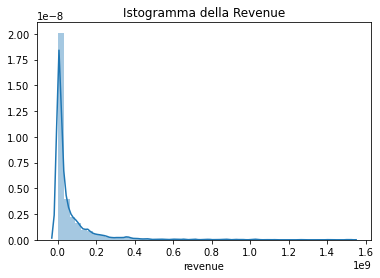

In [21]:
#sns.set(rc = {'figure.figsize':(15,3)})
sns.distplot(a = train['revenue']).set_title("Istogramma della Revenue")

Text(0.5, 1.0, 'Boxplot della Revenue')

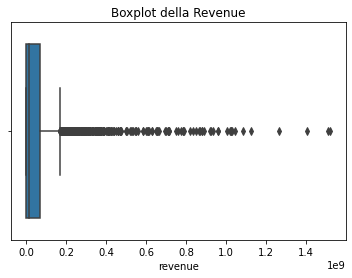

In [22]:
#sns.set(rc = {'figure.figsize':(15,3)})
sns.boxplot(x = train['revenue']).set_title("Boxplot della Revenue")

### Release Date
La data, nel dataframe, è in formato stringa: poco utile.
Vogliamo trasformarla in più colonne indicanti l'anno, il mese, il giorno della settimana e la settimana nell'anno. 

In [23]:
# Coversione della data da tipo stringa a tipo data
train["release_date"] = pd.to_datetime(train["release_date"], errors = "coerce", infer_datetime_format=True)

In [24]:
# Splitting della data in Anno, Mese, N° settimana e Giorno della settimana.
train["year_release"] = train["release_date"].dt.year
train["month_release"] = train["release_date"].dt.month
train["week_of_year_release"] = train["release_date"].dt.weekofyear
train["day_of_week_release"] = train["release_date"].dt.weekday

In [25]:
# Rimozione della features modificata
train.drop(labels=["release_date"], axis='columns', inplace=True)

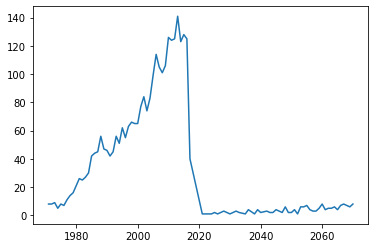

In [26]:
plt.plot(train.groupby("year_release").size())

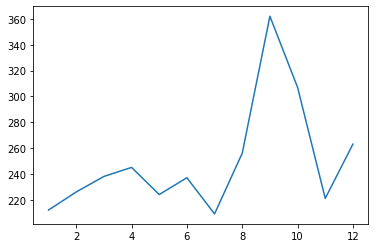

In [27]:
plt.plot(train.groupby("month_release").size())

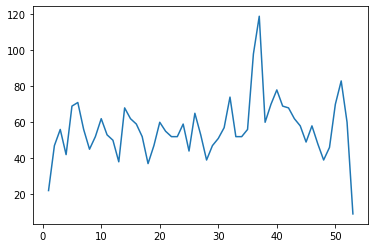

In [28]:
plt.plot(train.groupby("week_of_year_release").size())

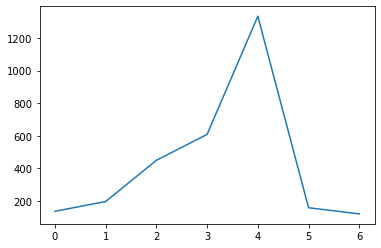

In [29]:
plt.plot(train.groupby("day_of_week_release").size())

### Belongs To Collection

In [37]:
df_belongsToCollection = find_frequency("belongs_to_collection", train)
df_belongsToCollection.head()

,belongs_to_collection
Hot Tub Time Machine Collection,1
The Princess Diaries Collection,2
The Muppet Collection,2
Rocky Collection,4
Revenge of the Nerds Collection,1


<BarContainer object of 422 artists>

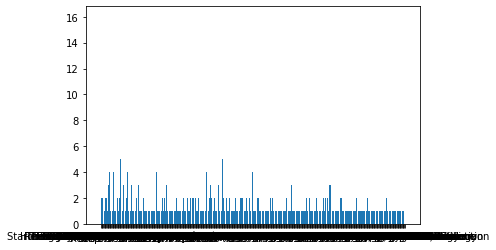

In [38]:
# TODO: da sistemare il grafico
plt.bar(x = df_belongsToCollection.index, height = df_belongsToCollection.iloc[:,0])

Osservando il grafico, vediamo che parecchie collection hanno un film solo che gli appartiene, questo comporta il fatto che la loro presenza non sarà significativa, quindi possiamo tenere solamente le collection che hanno almeno 2 film che gli appartengano.

### Genres

In [39]:
df_genres = find_frequency("genres", train)
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, Comedy to TV Movie
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   genres  20 non-null     int64
dtypes: int64(1)
memory usage: 320.0+ bytes


In [34]:
plt.bar(x = df_genres.index, height = df_genres.iloc[:,0])

NameError: name 'df_genres' is not defined

### Production companies

In [40]:
df_productionCompanies = find_frequency("production_companies", train)
df_productionCompanies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3695 entries, Paramount Pictures to Quick Six Entertainment
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   production_companies  3695 non-null   int64
dtypes: int64(1)
memory usage: 57.7+ KB


In [41]:
df_productionCompanies.describe(include="all")

,production_companies
count,3695.000000
mean,2.190798
std,7.032689
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,202.000000


<BarContainer object of 3695 artists>

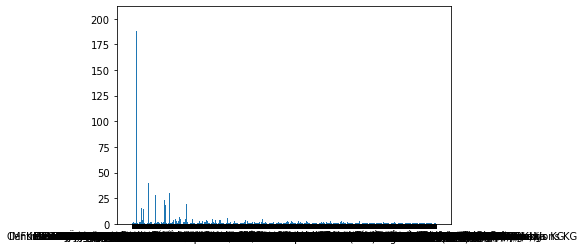

In [43]:
plt.bar(x = df_productionCompanies.index, height = df_productionCompanies.iloc[:,0])

In [42]:
Counter(values_to_list("production_companies", train)).most_common(50)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23),
 ('Castle Rock Entertainment', 21),
 ('Epsilon Motion Pictures', 21),
 ('Morgan Creek Productions', 21),
 ('Original Film', 21),
 ('Focus 

Osserviamo innanzitutto che abbiamo troppe case di produzione, di cui la maggior parte non significative, in quanto compaiono in pochi film. Decideremo poi quante tenerne.

### Production countries

In [44]:
df_productionCountries = find_frequency("production_countries", train)
df_productionCountries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, United States of America to Indonesia
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   production_countries  74 non-null     int64
dtypes: int64(1)
memory usage: 1.2+ KB


In [45]:
df_productionCountries.describe(include="all")

,production_countries
count,74.000000
mean,53.770270
std,268.472776
min,1.000000
25%,1.000000
50%,5.000000
75%,16.500000
max,2282.000000


In [ ]:
plt.bar(x = df_productionCountries.index, height = df_productionCountries.iloc[:,0])

In [46]:
Counter(values_to_list("production_countries", train)).most_common(30)

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10),
 ('Hungary', 9),
 ('United Arab Emirates', 9),
 ('Austria', 8),
 ('Switzerland', 8),
 ('Romania', 8)]

Osserviamo che abbiamo parecchie nazioni produttrici di film, che molte hanno pochi film fatti e che abbiamo un enorme varianza dei dati. Decidiremo successivamente quante tenerne

### Spoken Languages

In [47]:
df_spokenLanguages = find_frequency("spoken_languages", train)
df_spokenLanguages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, English to Hrvatski
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   spoken_languages  56 non-null     int64
dtypes: int64(1)
memory usage: 896.0+ bytes


In [48]:
df_spokenLanguages.describe(include="all")

,spoken_languages
count,56.000000
mean,77.803571
std,350.362847
min,1.000000
25%,3.000000
50%,9.000000
75%,29.250000
max,2618.000000


In [ ]:
plt.bar(x = df_spokenLanguages.index, height = df_spokenLanguages.iloc[:,0])

In [51]:
Counter(values_to_list("spoken_languages", train)).most_common(20)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27),
 ('Polski', 25),
 ('Magyar', 24),
 ('Latin', 23),
 ('svenska', 22),
 ('ภาษาไทย', 22)]

### Keywords

In [52]:
df_keywords = find_frequency("Keywords", train)
df_keywords.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7400 entries, time travel to insurance risk manager
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Keywords  7400 non-null   int64
dtypes: int64(1)
memory usage: 115.6+ KB


In [53]:
df_keywords.describe(include="all")

,Keywords
count,7400.00000
mean,2.92973
std,6.25387
min,1.00000
25%,1.00000
50%,1.00000
75%,3.00000
max,175.00000


In [ ]:
plt.bar(x = df_keywords.index, height = df_keywords.iloc[:,0])

In [54]:
Counter(values_to_list("Keywords", train)).most_common(100)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('friendship', 72),
 ('sex', 71),
 ('suspense', 67),
 ('sequel', 66),
 ('love', 64),
 ('police', 64),
 ('teenager', 61),
 ('nudity', 57),
 ('female nudity', 53),
 ('drug', 52),
 ('prison', 50),
 ('musical', 49),
 ('high school', 49),
 ('los angeles', 48),
 ('new york', 47),
 ('family', 45),
 ('father son relationship', 44),
 ('kidnapping', 41),
 ('investigation', 41),
 ('wedding', 40),
 ('3d', 40),
 ('detective', 38),
 ('london england', 38),
 ('paris', 37),
 ('based on comic', 37),
 ('robbery', 36),
 ('based on true story', 35),
 ('dying and death', 34),
 ('escape', 34),
 ('alien', 34),
 ('brother brother relationship', 34),
 ('prostitute', 34),
 ('suicide', 33),
 ('rape', 33),
 ('corruption', 33),
 ('death', 32),
 ('superhero', 32),
 (

## PCA

In [62]:
# Colonne a cui applicare OneHotEncoding
columns_to_dummy = ["belongs_to_collection", "original_language", "genres", "production_companies", "production_countries", "spoken_languages", "Keywords"]

In [56]:
reduced = reduce_columns(train, columns_to_dummy)

In [61]:
#rimozione delle features modificate
train.drop(labels=columns_to_dummy, axis='columns', inplace=True)

In [63]:
reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 590 entries, budget to Keywords369
dtypes: float64(584), int64(6)
memory usage: 13.5 MB


## Primo Test di un Decision Tree

In [64]:
#reduced.astype(np.float32)
#np.any(np.isnan(reduced))
#np.all(np.isfinite(mat))
reduced = reduced.reset_index()

In [65]:
clean_dataset(reduced)

,index,budget,popularity,runtime,revenue,year_release,month_release,week_of_year_release,day_of_week_release,belongs_to_collection0,...,Keywords360,Keywords361,Keywords362,Keywords363,Keywords364,Keywords365,Keywords366,Keywords367,Keywords368,Keywords369
0,0.0,14000000.0,6.575393,93.0,12314651.0,2015.0,2.0,8.0,4.0,-0.005536,...,0.004307,-0.004374,-0.008844,0.051224,0.016111,-0.008861,0.001753,-0.009309,-0.015240,-0.013124
1,1.0,40000000.0,8.248895,113.0,95149435.0,2004.0,8.0,32.0,4.0,-0.005934,...,-0.034291,-0.010710,-0.001237,0.086068,-0.010236,0.096045,-0.005936,0.018641,0.007567,-0.003873
2,2.0,3300000.0,64.299990,105.0,13092000.0,2014.0,10.0,41.0,4.0,-0.005189,...,-0.016951,-0.005576,-0.041605,-0.202914,-0.065527,-0.039792,-0.108476,-0.156942,-0.249683,0.044209
3,3.0,1200000.0,3.174936,122.0,16000000.0,2012.0,3.0,10.0,4.0,-0.005189,...,0.054333,-0.034397,0.050100,0.087008,0.012310,-0.036352,0.034916,-0.000672,-0.093985,0.008260
4,4.0,0.0,1.148070,118.0,3923970.0,2009.0,2.0,6.0,3.0,-0.005189,...,0.002514,-0.000863,0.000889,0.001189,0.001010,0.001663,-0.000352,0.001843,-0.004211,0.000770


In [66]:
model = tree.DecisionTreeRegressor()

In [67]:
X = reduced.drop("revenue", axis='columns', inplace = False)
y = reduced["revenue"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [69]:
y_pred = model.predict(X_test)
print ("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred) )

Test Accuracy: 0.0
